In [19]:
import sys
sys.path.append('..')

import pandas as pd
import src.features.build_features as bf

pd.options.display.max_columns = None
rnd = 42

### Reasonable filtering

In [43]:
useful_cols = ['Event', 'Site', 'Date', 'White', 'Black', 'WhiteElo', 'BlackElo', 'WhiteTitle', 'BlackTitle',
              'Result']

df = pd.read_csv('../data/interim/21_12_2021.csv', usecols=useful_cols)
df = df.query('BlackElo>1800 and WhiteElo>1800')
df[['WhiteTitle', 'BlackTitle']] = df[['WhiteTitle', 'BlackTitle']].fillna('No Title')
df = bf.impute_rare_titles(df)
df = bf.make_otb_feature(df)
df = df.drop(['Event', 'Site', 'Date', 'White', 'Black'], axis=1)
df = df[df['Result'].isin(['1-0', '0-1', '1/2-1/2'])]

### Train-test split

In [44]:
from sklearn.model_selection import train_test_split

y = df['Result']
X = df.drop(['Result'], axis=1)

X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.2, random_state=rnd)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=rnd)

## CatBoost

In [45]:
from catboost import Pool

cat_features = ['BlackTitle', 'WhiteTitle', 'Otb']

all_pool = Pool(X, y, cat_features=cat_features)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [58]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1_000,
    custom_loss=['TotalF1', 'Accuracy', 'AUC'],
    early_stopping_rounds=20
)


model.fit(train_pool, eval_set=val_pool, plot=True, verbose=50)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.124258
0:	learn: 1.0670870	test: 1.0668770	best: 1.0668770 (0)	total: 677ms	remaining: 11m 16s
50:	learn: 0.9219914	test: 0.9201456	best: 0.9201456 (50)	total: 30.1s	remaining: 9m 20s
100:	learn: 0.9206708	test: 0.9189716	best: 0.9189716 (100)	total: 1m 1s	remaining: 9m 6s
150:	learn: 0.9201161	test: 0.9185928	best: 0.9185928 (150)	total: 1m 28s	remaining: 8m 19s
200:	learn: 0.9197028	test: 0.9183781	best: 0.9183781 (200)	total: 2m 2s	remaining: 8m 6s
250:	learn: 0.9194349	test: 0.9182907	best: 0.9182907 (250)	total: 2m 33s	remaining: 7m 37s
300:	learn: 0.9191720	test: 0.9182002	best: 0.9182002 (300)	total: 3m 9s	remaining: 7m 20s
350:	learn: 0.9189407	test: 0.9181631	best: 0.9181631 (350)	total: 3m 41s	remaining: 6m 48s
400:	learn: 0.9187203	test: 0.9181224	best: 0.9181183 (398)	total: 4m 9s	remaining: 6m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9181183005
bestIteration = 398

Shrink model to first 399 iterations.


Confusion matrix, without normalization
[[26222 10125  8409]
 [ 8871 37595  8639]
 [11067 14154 15115]]
Normalized confusion matrix
[[0.59 0.23 0.19]
 [0.16 0.68 0.16]
 [0.27 0.35 0.37]]


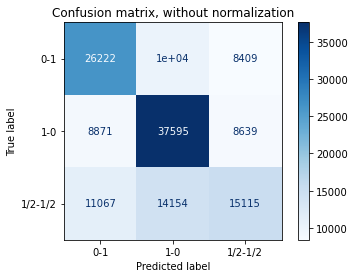

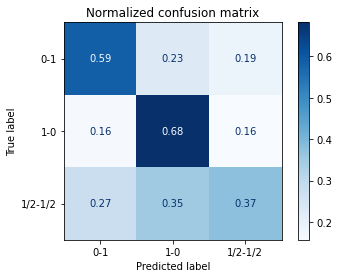

In [62]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()